In [2]:
import pandas as pd
import functions as func
import pickle
import xgboost as xgb
from patsy import dmatrices
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae



In [3]:
api_url = 'https://gamesheetstats.com/api/useScoredGames/getSeasonScores/6642?filter[limit]=10000'
df_season1 = func.parse_rest_api_to_pandas(api_url)

df_season1 = df_season1[['date','game.number','game.type','game.gameId','game.homeTeam.id','game.homeTeam.name','game.homeTeam.division','game.visitorTeam.id','game.visitorTeam.name','game.visitorTeam.division','game.finalScore.homeGoals','game.finalScore.visitorGoals']]
df_season1 = df_season1.rename(columns={'game.number':'game_number','game.type':'game_type','game.gameId':'game_id','game.homeTeam.id':'hometeam_id','game.homeTeam.name':'hometeam_name','game.homeTeam.division':'hometeam_division','game.visitorTeam.id':'visitorteam_id','game.visitorTeam.name':'visitorteam_name','game.visitorTeam.division':'visitorteam_division','game.finalScore.homeGoals':'homegoals','game.finalScore.visitorGoals':'visitorgoals'})
df_season1

,date,game_number,game_type,game_id,hometeam_id,hometeam_name,hometeam_division,visitorteam_id,visitorteam_name,visitorteam_division,homegoals,visitorgoals
0,"Sat, Feb 15, 2025",None,Regular Season,2248963,248315,Cyclones Academy 14U Tier 1,14U Tier 1,248128,Seacoast Performance Academy Spartans 14U,14U Tier 1,0,8
1,"Sat, Feb 15, 2025",6950204,Regular Season,2238756,251274,Northern Cyclones Squirt Minor Gold,10U Tier 4,248303,Keene 10U White,10U Tier 4,6,4
2,"Sat, Feb 15, 2025",6703687,Regular Season,1941510,248474,Manchester 12U Major II - Engvik,12U Tier 3,248475,Manchester 12U Minor I - Hawkes,12U Tier 3,9,3
3,"Sat, Feb 15, 2025",6749225,Regular Season,2244541,248654,Concord 11U Elite - Poirier,12U Tier 4,250808,Granite State Wild PW Minor 11U,12U Tier 4,1,9
4,"Sat, Feb 15, 2025",6694611,Regular Season,1941221,251301,Upper Valley 10u Blue,10U Tier 3,248656,Berlin 10U Paiva,10U Tier 3,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
973,"Sat, Sep 7, 2024",6674448,Regular Season,1907924,248481,Manchester 18U - Baker,18U Tier 2,251195,NH Mountain Kings 18U AAA Full Season,18U Tier 2,2,2
974,"Sat, Sep 7, 2024",6676288,Regular Season,1907923,250620,Granite State Wild 18U Midget (Strum),18U Tier 4,250602,Back Bay Indians 18U,18U Tier 4,3,5
975,"Sat, Sep 7, 2024",6676268,Regular Season,1907921,250622,Granite State Wild Midget 18U (Behan),18U Tier 2,250819,NH Mountain Kings U18-Split,18U Tier 2,2,4
976,"Sat, Sep 7, 2024",6675036,Regular Season,1907856,248479,Manchester 16U - Bernard,16U Tier 2,250655,NH Avalanche 16U Tier 1,16U Tier 2,6,3


In [4]:
# Reverse home & visitor team metrics to get a full dataset
df_season2 = df_season1.rename(columns={'hometeam_id':'visitorteam_id','hometeam_name':'visitorteam_name','hometeam_division':'visitorteam_division','visitorteam_id':'hometeam_id','visitorteam_name':'hometeam_name','visitorteam_division':'hometeam_division','homegoals':'visitorgoals','visitorgoals':'homegoals'})
df_season1['keep']='1'
df_season2['keep']='0'

df_season = pd.concat([df_season1, df_season2], ignore_index=True, axis=0, join="inner")

df_season['goal_diff'] = df_season['homegoals'] - df_season['visitorgoals']

for col in df_season.columns.to_list():
    if col in ('homegoals','visitorgoals','goal_diff'):
        df_season[col] = pd.to_numeric(df_season[col])
    elif col =='date':
        df_season[col] = pd.to_datetime(df_season[col])
    else:
        df_season[col] = df_season[col].astype('category')
        
df_season.dtypes

date                    datetime64[ns]
game_number                   category
game_type                     category
game_id                       category
hometeam_id                   category
hometeam_name                 category
hometeam_division             category
visitorteam_id                category
visitorteam_name              category
visitorteam_division          category
homegoals                        int64
visitorgoals                     int64
keep                          category
goal_diff                        int64
dtype: object

R2:  -0.0974
MAE:  3.0207


C:\Users\baref\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


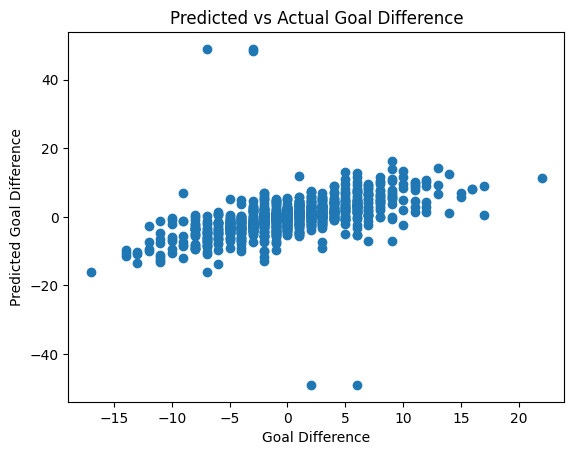

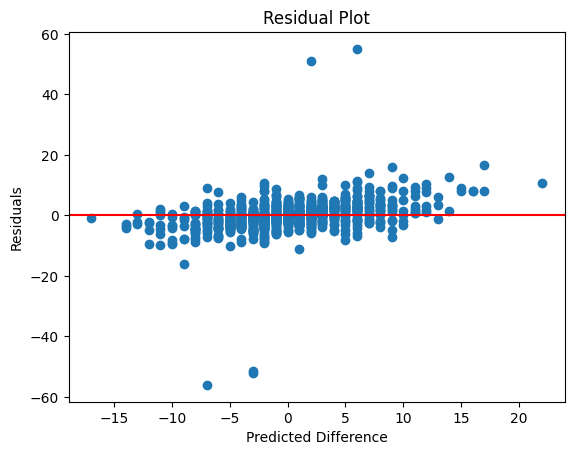

In [27]:
# GLM: Poisson (Home Goals)
glm_forumula = (''' homegoals ~ hometeam_id + visitorteam_id ''')

y, X = dmatrices(glm_forumula, data=df_season, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)


glm_P = PoissonRegressor( alpha=0, solver='lbfgs', max_iter=1000, verbose=0)
glm_P.fit(X_train, y_train)

pred = pd.DataFrame(glm_P.predict(X), columns=['pred_home'])
out = pd.concat([df_season, pred], axis=1)


out2 = out[['game_id', 'visitorteam_id', 'pred_home']].rename(columns={'visitorteam_id': 'hometeam_id', 'pred_home': 'pred_visitor'})
out_full = pd.merge(out, out2, on=['game_id', 'hometeam_id'])
del out, out2

out_full['pred_diff'] = out_full['pred_home'] - out_full['pred_visitor']
out_full = out_full[(out_full['keep'] == '1')]
# out_full = out_full[(out_full['keep'] == '1') & (out_full['hometeam_division']=='10U Tier 4')]


print('R2: ', round(r2_score(out_full['goal_diff'], out_full['pred_diff']), 4))
print('MAE: ', round(mae(out_full['goal_diff'], out_full['pred_diff']), 4))


plt.scatter(out_full['goal_diff'], out_full['pred_diff'])
plt.xlabel('Goal Difference')
plt.ylabel('Predicted Goal Difference')
plt.title('Predicted vs Actual Goal Difference')
plt.show()


residuals = out_full['goal_diff'] - out_full['pred_diff']

plt.scatter(out_full['goal_diff'], residuals)
plt.xlabel('Predicted Difference')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

C:\Users\baref\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2:  0.2262
MAE:  3.2924


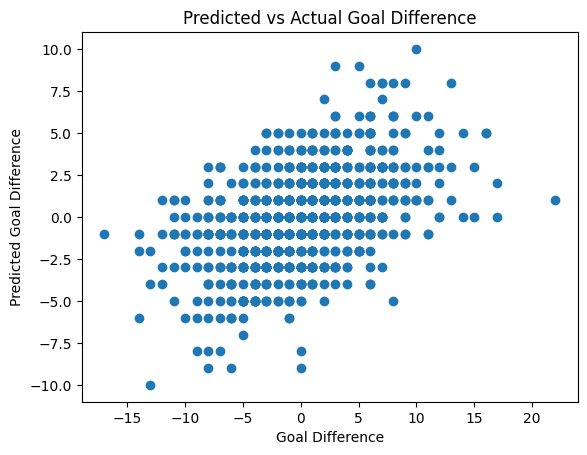

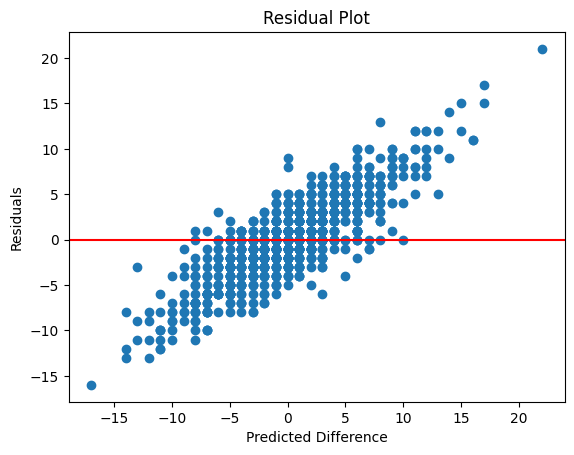

In [28]:
# GLM: Logistic (Home Goals)
glm_forumula = (''' homegoals ~ hometeam_id + visitorteam_id ''')

y, X = dmatrices(glm_forumula, data=df_season, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)


glm_Log = LogisticRegression()
glm_Log.fit(X_train, y_train)

pred = pd.DataFrame(glm_Log.predict(X), columns=['pred_home'])
out = pd.concat([df_season, pred], axis=1)


out2 = out[['game_id', 'visitorteam_id', 'pred_home']].rename(columns={'visitorteam_id': 'hometeam_id', 'pred_home': 'pred_visitor'})
out_full = pd.merge(out, out2, on=['game_id', 'hometeam_id'])
del out, out2

out_full['pred_diff'] = out_full['pred_home'] - out_full['pred_visitor']
out_full = out_full[(out_full['keep'] == '1')]


print('R2: ', round(r2_score(out_full['goal_diff'], out_full['pred_diff']), 4))
print('MAE: ', round(mae(out_full['goal_diff'], out_full['pred_diff']), 4))


plt.scatter(out_full['goal_diff'], out_full['pred_diff'])
plt.xlabel('Goal Difference')
plt.ylabel('Predicted Goal Difference')
plt.title('Predicted vs Actual Goal Difference')
plt.show()


residuals = out_full['goal_diff'] - out_full['pred_diff']

plt.scatter(out_full['goal_diff'], residuals)
plt.xlabel('Predicted Difference')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

R2:  -3.4034217959764014e+27
MAE:  56116112434878.125


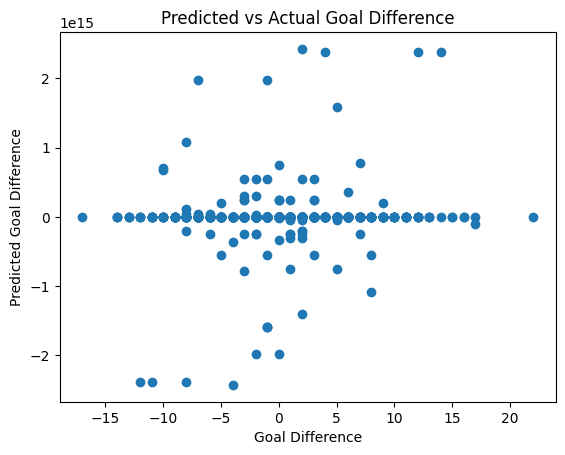

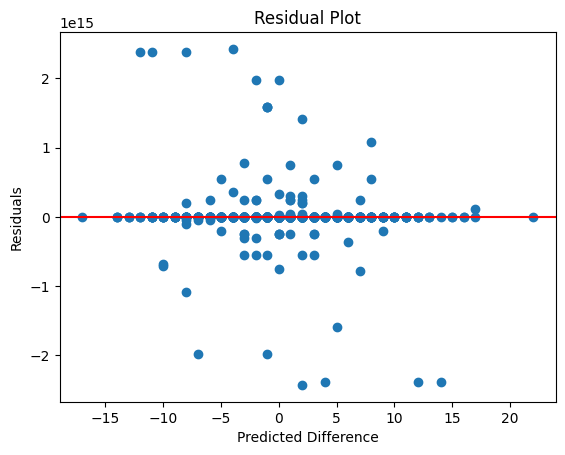

In [29]:
# GLM: Linear Regression (goal difference)
glm_forumula = (''' homegoals ~ hometeam_id + visitorteam_id ''')

y, X = dmatrices(glm_forumula, data=df_season, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)


glm_LR = LinearRegression()
glm_LR.fit(X_train, y_train)

pred = pd.DataFrame(glm_LR.predict(X), columns=['pred_home'])
out = pd.concat([df_season, pred], axis=1)


out2 = out[['game_id', 'visitorteam_id', 'pred_home']].rename(columns={'visitorteam_id': 'hometeam_id', 'pred_home': 'pred_visitor'})
out_full = pd.merge(out, out2, on=['game_id', 'hometeam_id'])
del out, out2

out_full['pred_diff'] = out_full['pred_home'] - out_full['pred_visitor']
out_full = out_full[(out_full['keep'] == '1')]


print('R2: ', round(r2_score(out_full['goal_diff'], out_full['pred_diff']), 4))
print('MAE: ', round(mae(out_full['goal_diff'], out_full['pred_diff']), 4))


plt.scatter(out_full['goal_diff'], out_full['pred_diff'])
plt.xlabel('Goal Difference')
plt.ylabel('Predicted Goal Difference')
plt.title('Predicted vs Actual Goal Difference')
plt.show()


residuals = out_full['goal_diff'] - out_full['pred_diff']

plt.scatter(out_full['goal_diff'], residuals)
plt.xlabel('Predicted Difference')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [100]:
out_full[(out_full['game_id']=='2238756')]

,date,game_number,game_type,game_id,hometeam_id,hometeam_name,hometeam_division,visitorteam_id,visitorteam_name,visitorteam_division,homegoals,visitorgoals,keep,goal_diff,pred_home,pred_visitor,pred_diff
1,2025-02-15,6950204,Regular Season,2238756,251274,Northern Cyclones Squirt Minor Gold,10U Tier 4,248303,Keene 10U White,10U Tier 4,6,4,1,2,3.0,1.0,2.0
